In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
np.random.seed(10)

def f(x):
    return 1 + x**2

def sampling(n_sample=500, scale=10):
    data = []
    X = scale * (np.random.random_sample(n_sample) - 0.5) # - 0.5 _ 0.5
    for i in range(n_sample):
        yi = f(X[i])
        data.append([X[i], yi])
#     data.append([X, y])
    return np.array(data)

In [3]:
def sample_Z(n_sample, n_dim):
    return np.random.uniform(-1., 1., size=[n_sample, n_dim])

In [4]:
data = sampling()
print(data.shape)

(500, 2)


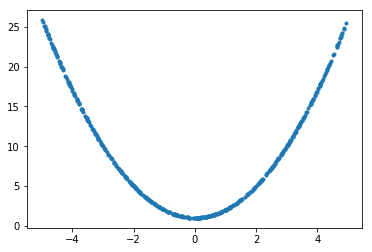

In [5]:
plt.scatter(data[:, 0], data[:, 1], marker='.')
plt.show()

In [6]:
hidden_size = 32

def GNet(Z, reuse=False):
    with tf.variable_scope("GNet", reuse=reuse):
        h1 = tf.layers.dense(Z, units=hidden_size, activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1, units=hidden_size, activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2, 2)
    return out

def DNet(X, reuse=False):
    with tf.variable_scope('DNet', reuse=reuse):
        h1 = tf.layers.dense(X, units=hidden_size, activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1, units=hidden_size, activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2, 2)
        out = tf.layers.dense(h3, 1)
        return out, h3

In [7]:
X = tf.placeholder(tf.float32, [None, 2], name="X")
Z = tf.placeholder(tf.float32, [None, 2], name="Z")

In [8]:
# G_sample = GNet(Z)
# r_logits, r_visual = DNet(X)
# f_logits, f_visual = DNet(G_sample, reuse=True)

In [9]:
G_sample = GNet(Z)
r_logits, r_visual = DNet(X)
f_logits, f_visual = DNet(G_sample, reuse=True)

D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits, labels=tf.ones_like(r_logits)) 
                       + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.zeros_like(f_logits)))

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.ones_like(f_logits)))

In [10]:
D_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='DNet')
G_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='GNet')

D_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(D_loss, var_list=D_var)
G_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=G_var)

init = tf.global_variables_initializer()

In [11]:
# X_batch = np.random.randn(100, 2)
# Z_batch = np.random.randn(100, 2)
# writer = tf.summary.FileWriter('./graphs/simple_gan', tf.get_default_graph())
# with tf.Session() as sess:
#     sess.run(init)
#     sess.run(D_step, feed_dict={X: X_batch, Z: Z_batch})

In [12]:
batch_size = 32
loss_G_list = []
loss_D_list = []


with tf.Session() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter('./graphs/simple_gan', tf.get_default_graph())
    for i in range(20000):
        
        X_batch = sampling(n_sample=batch_size)
        Z_batch = sample_Z(batch_size, 2)
        _, loss_D = sess.run([D_step, D_loss], feed_dict={X: X_batch, Z: Z_batch})
        
        Z_batch = sample_Z(batch_size, 2)
        _, loss_G = sess.run([G_step, G_loss], feed_dict={Z: Z_batch})
        
        if i%10==0:
            loss_G_list.append(loss_G)
            loss_D_list.append(loss_D)
            
        
        
        if i%500==0:
            print("Iteration: %d\t G_loss: %.4f\t D_loss: %.4f"%(i, loss_G, loss_D))
        
    z_ = sample_Z(100, 2)
    data_ = sess.run(G_sample, feed_dict={Z: z_})

Iteration: 0	 G_loss: 0.7069	 D_loss: 1.3789
Iteration: 500	 G_loss: 0.7101	 D_loss: 0.9430
Iteration: 1000	 G_loss: 0.8966	 D_loss: 0.8845
Iteration: 1500	 G_loss: 0.8898	 D_loss: 1.3343
Iteration: 2000	 G_loss: 0.8483	 D_loss: 1.4147
Iteration: 2500	 G_loss: 0.8731	 D_loss: 1.3417
Iteration: 3000	 G_loss: 0.7938	 D_loss: 1.2942
Iteration: 3500	 G_loss: 0.8285	 D_loss: 1.2580
Iteration: 4000	 G_loss: 0.8323	 D_loss: 1.1537
Iteration: 4500	 G_loss: 0.8316	 D_loss: 1.3026
Iteration: 5000	 G_loss: 0.8285	 D_loss: 1.2685
Iteration: 5500	 G_loss: 0.8184	 D_loss: 1.2728
Iteration: 6000	 G_loss: 0.8844	 D_loss: 1.2617
Iteration: 6500	 G_loss: 0.8342	 D_loss: 1.3078
Iteration: 7000	 G_loss: 0.9116	 D_loss: 1.2391
Iteration: 7500	 G_loss: 0.8056	 D_loss: 1.2792
Iteration: 8000	 G_loss: 0.7799	 D_loss: 1.3298
Iteration: 8500	 G_loss: 0.7197	 D_loss: 1.3742
Iteration: 9000	 G_loss: 0.6818	 D_loss: 1.3075
Iteration: 9500	 G_loss: 0.7237	 D_loss: 1.3093
Iteration: 10000	 G_loss: 0.9161	 D_loss: 1.

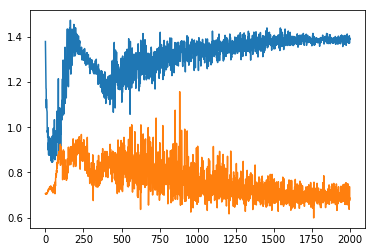

In [13]:
xplot = range(2000)
plt.plot(xplot, loss_D_list)
plt.plot(xplot, loss_G_list)
plt.show()

In [14]:
# z = sample_Z(100, 2)
# with tf.Session() as sess:
#     sess.run(init)
#     data = sess.run(G_sample, feed_dict={Z: z})
# print(data.shape)

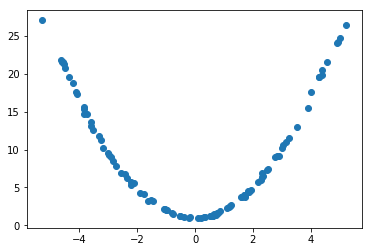

In [15]:
plt.scatter(data_[:, 0], data_[:, 1])
plt.show()